In [3]:
import os
import sys
import requests
import datetime
import pandas as pd
import numpy as np
import torch, torchvision, torchaudio
import pytorch_lightning as pl
import wandb
import json
import copy
import shutil

import matplotlib.pyplot as plt
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger
from transformers import AutoImageProcessor, DeformableDetrForObjectDetection
from transformers import DeformableDetrConfig, DeformableDetrImageProcessor
from pytorch_lightning import Trainer
from PIL import Image, ImageDraw

In [4]:


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, image_name):
        ann_file = os.path.join(img_folder, image_name)
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

processor = DeformableDetrImageProcessor.from_pretrained("jozhang97/deta-resnet-50")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create Train and Validation Dataset
  #Minimal Dataset
# train_dataset = CocoDetection(img_folder='../../../old/BAA/Data/train', processor=processor, image_name="coco_train.json")
# val_dataset = CocoDetection(img_folder='../../../old/BAA/Data/val', processor=processor, image_name="coco_val.json")

  #Maximal Dataset
train_dataset = CocoDetection(img_folder='../../../old/BAA/Data/train_max', processor=processor, image_name="coco_train_max.json")
val_dataset = CocoDetection(img_folder='../../../old/BAA/Data/val_max', processor=processor, image_name="coco_val_max.json")

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)
batch = next(iter(train_dataloader))



loading annotations into memory...


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Done (t=0.21s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 859
Number of validation examples: 215


In [5]:
class DeformableDetr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         # we specify the "no_timm" variant here to not rely on the timm library
         # for the convolutional backbone
         self.model = DeformableDetrForObjectDetection.from_pretrained("SenseTime/deformable-detr",
                                                             num_labels=len(id2label),
                                                             auxiliary_loss=True,
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.save_hyperparameters()
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [6]:
# Training




# login to weights and biases, to relogin: wandb.login(key="YOUR KEY", relogin=True)
wandb.login()

date = datetime.datetime.now()
run_name = "Run at the {}".format(date)

lr = 1e-4
lr_backbone=1e-5
weight_decay=1e-4

project = "BAA_Book_Damage_Detection"

wandb.init(
    project=project,
    name=run_name,
    config={"learning_rate_transformer": lr,
            "learning_rate_backbone": lr_backbone,
            "weight_decay": weight_decay,
            "architecture": "DeformableDetr",
            "dataset": "All_Data",
            "train_set_size": len(train_dataset)}
    )

model = DeformableDetr(lr=lr, lr_backbone=lr_backbone, weight_decay=weight_decay)

model.to(device)

# outputs = model(pixel_values=batch['pixel_values'].to(device), pixel_mask=batch['pixel_mask'].to(device))
# print(outputs.logits.shape)

max_steps_var = 300

wandb_logger = WandbLogger("DeformableDetr", "../models/", project=project, log_model=True, checkpoint_name=f"DeformableDetr_{max_steps_var}_Steps")
trainer = Trainer(max_steps=max_steps_var, gradient_clip_val=0.1, logger=wandb_logger)
trainer.fit(model)

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michael-infanger (damaged-books-detection-ml). Use `wandb login --relogin` to force relogin


config.json:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Michael\.cache\huggingface\hub\models--SenseTime--deformable-detr. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/161M [00:00<?, ?B/s]

Some weights of the model checkpoint at SenseTime/deformable-detr were not used when initializing DeformableDetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeformableDetrForObjectDetection wer

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.


In [7]:
# load the checkpoint

run = wandb.init()
artifact = run.use_artifact('damaged-books-detection-ml/BAA_Book_Damage_Detection/DeformableDetr_300_Steps:v0', type='model')
artifact_dir = artifact.download()

model = DeformableDetr.load_from_checkpoint(artifact_dir + "/model.ckpt")

wandb: Downloading large artifact DeformableDetr_300_Steps:v0, 457.51MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4
Some weights of the model checkpoint at SenseTime/deformable-detr were not used when initializing DeformableDetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing 

In [8]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DeformableDetr(
  (model): DeformableDetrForObjectDetection(
    (model): DeformableDetrModel(
      (backbone): DeformableDetrConvModel(
        (conv_encoder): DeformableDetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DeformableDetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DeformableDetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DeformableDetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplac

In [9]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

    # provide to metric
    # metric expects a list of dictionaries, each item
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/215 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.14s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

{'scores': tensor([0.2225, 0.2188, 0.2158, 0.2094, 0.2080, 0.2070, 0.2070, 0.2056, 0.2016],
       device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[ 993.0963,  634.0373, 1073.4508,  870.4496],
        [ 930.5730,  340.6819,  997.2572,  562.4009],
        [ 497.3173,  647.5463,  546.3956,  868.9961],
        [ 525.2883,  353.4408,  595.2859,  576.8163],
        [ 616.8891,  404.1926,  672.2991,  588.2486],
        [ 697.1907,  324.2236,  813.2905,  581.1198],
        [1020.0480,  369.3629, 1057.5999,  582.7568],
        [1155.7251,  627.9746, 1199.7583,  865.5608],
        [1074.2616,  318.2967, 1158.3180,  566.1489]], device='cuda:0')}
{'Schmutz': 9}
{'Schmutz': 13, 'Schäden': 4}


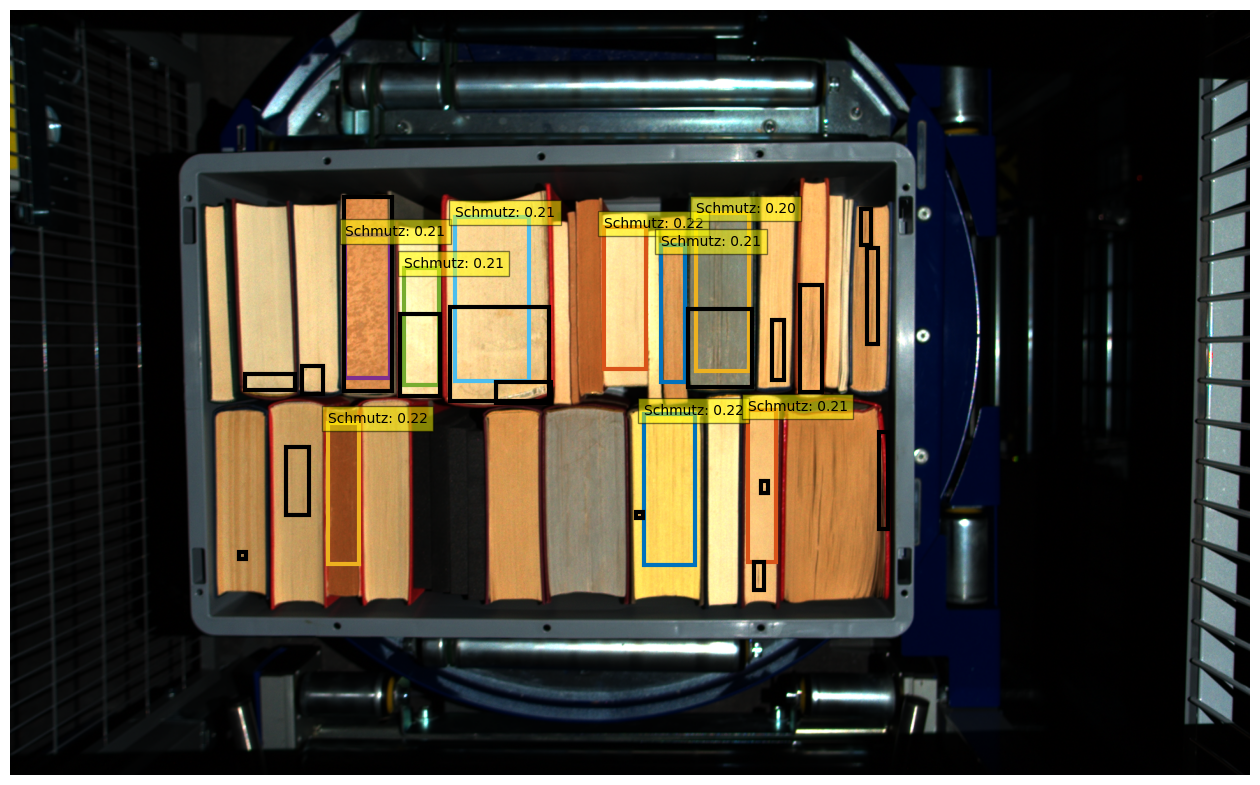

{'scores': tensor([0.2217, 0.2217, 0.2185, 0.2144, 0.2119, 0.2113, 0.2094, 0.2078, 0.2072,
        0.2043, 0.2039, 0.2023, 0.2020, 0.2020], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[ 707.9646,  655.3107,  756.5783,  873.8158],
        [1137.2767,  664.4559, 1184.1504,  881.1556],
        [ 496.1744,  674.2609,  548.3901,  880.9884],
        [1221.4119,  632.6187, 1268.3358,  861.2291],
        [1209.6458,  318.8582, 1262.3854,  560.4605],
        [1004.4647,  332.0913, 1046.0237,  558.5101],
        [1136.5316,  665.8102, 1177.4679,  869.7633],
        [ 694.9845,  336.3485,  736.3896,  559.5926],
        [ 796.1870,  321.1799,  837.7997,  534.7811],
        [ 772.8090,  648.8388,  812.6629,  874.4814],
        [1286.3679,  311.2425, 1340.4773,  552.6531],
        [ 848.8140,  654.7598,  881.9536,  863.5480],
        [ 598.4799,  665.0380,  638.7465,  869.2662],
        [ 970.8760,  647.7023, 1026.6593,  881.5892]

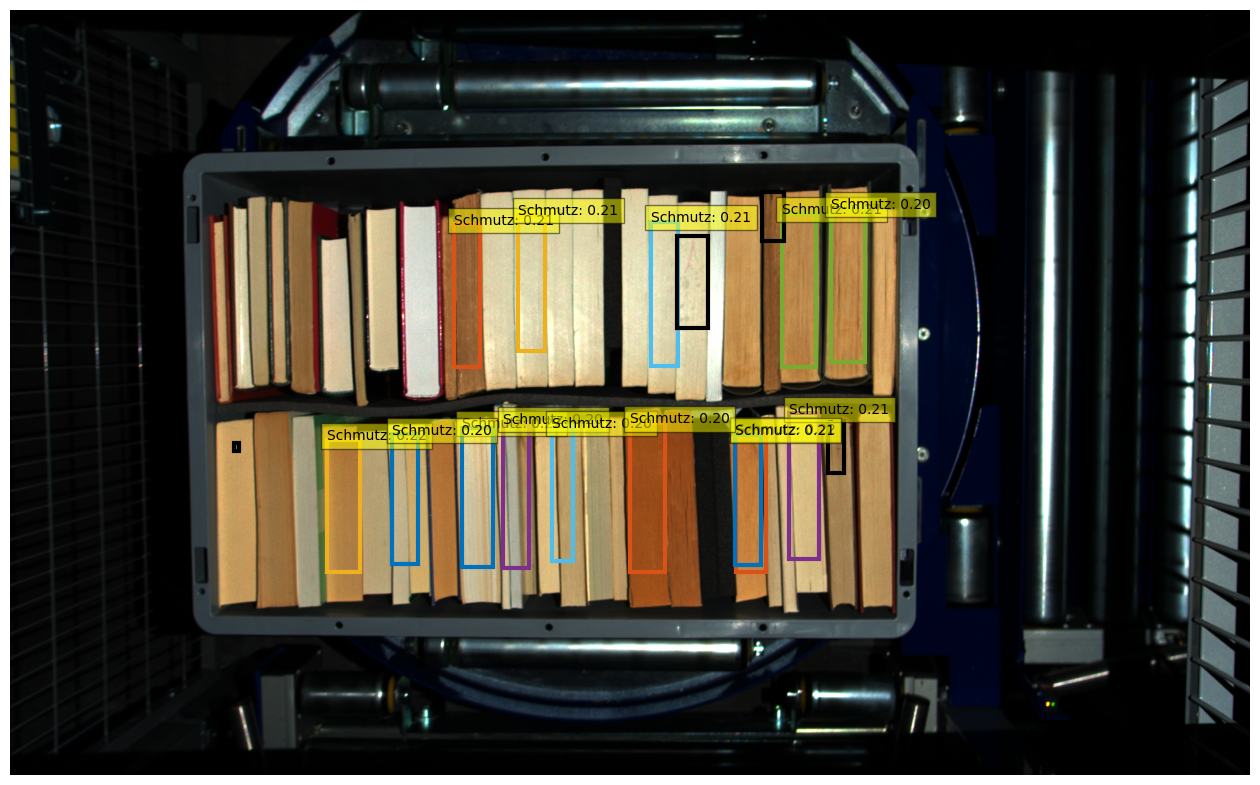

{'scores': tensor([0.2135, 0.2123, 0.2119, 0.2088, 0.2070, 0.2041], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[1013.7292,  626.5278, 1050.7759,  849.1407],
        [ 847.2488,  631.6331,  882.7148,  842.5612],
        [ 956.4274,  306.7376, 1051.3225,  565.1816],
        [ 883.9037,  625.2729,  915.6329,  825.3832],
        [ 610.1967,  312.5556,  667.4764,  540.5915],
        [1131.6083,  625.1667, 1168.2946,  846.3509]], device='cuda:0')}
{'Schmutz': 6}
{'Schmutz': 6, 'Sonstiges': 4, 'Wasser': 1}


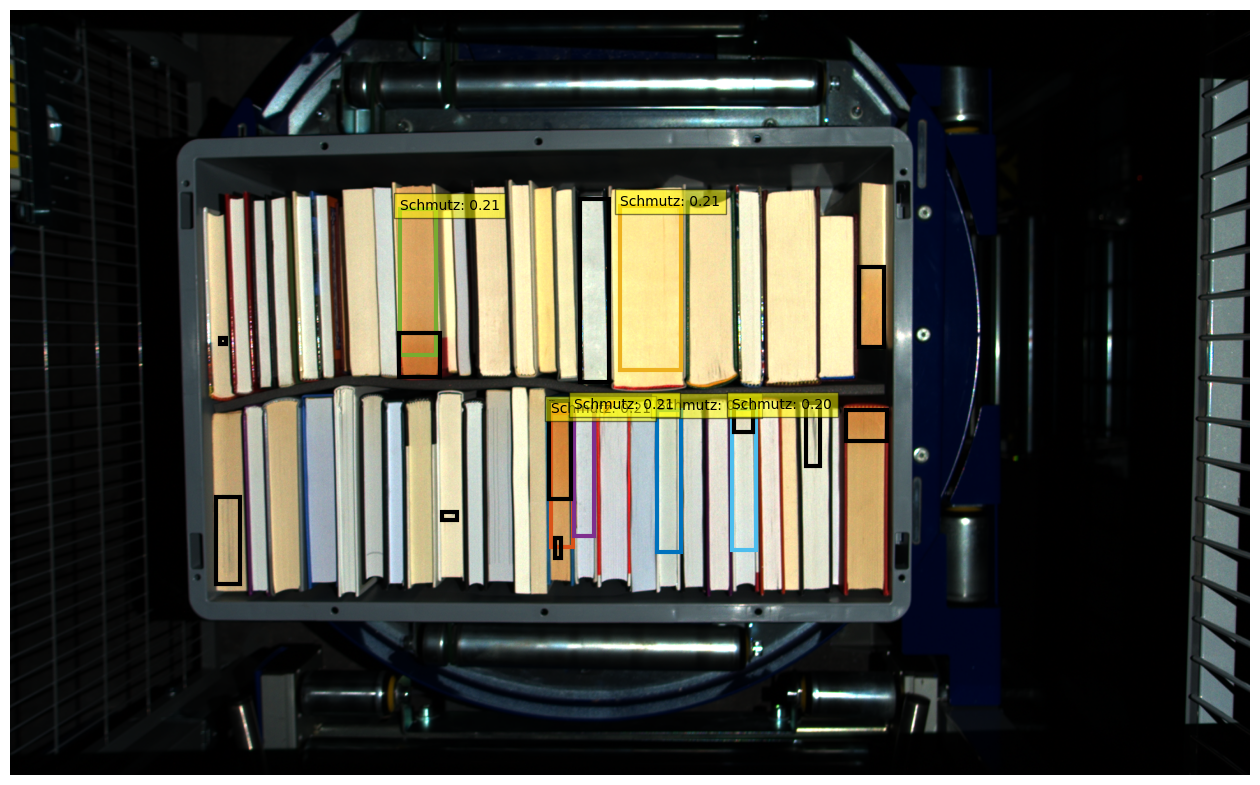

{'scores': tensor([0.2364, 0.2312, 0.2285, 0.2194, 0.2164, 0.2146, 0.2117, 0.2103, 0.2098,
        0.2094, 0.2072, 0.2057, 0.2052, 0.2020, 0.2018], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[ 388.4227,  299.2361,  435.5337,  501.0608],
        [ 646.3566,  283.8683,  695.5075,  495.6801],
        [ 863.2374,  284.2737,  922.8963,  492.4253],
        [1112.6565,  649.1723, 1169.9022,  851.8831],
        [ 976.5489,  646.0517, 1028.6387,  842.3985],
        [ 558.8112,  605.9448,  613.4255,  810.4102],
        [ 457.2059,  344.4380,  510.9760,  519.9349],
        [1130.1813,  285.1692, 1174.2761,  499.4805],
        [1192.1587,  641.1653, 1245.2646,  846.5261],
        [1128.8357,  294.1583, 1175.1764,  502.9922],
        [ 750.4470,  591.6586,  820.9460,  806.8600],
        [1037.4863,  648.3916, 1081.2734,  840.5498],
        [ 854.1880,  570.5646,  904.8923,  788.8559],
        [ 861.5726,  583.4908,  912.2906,

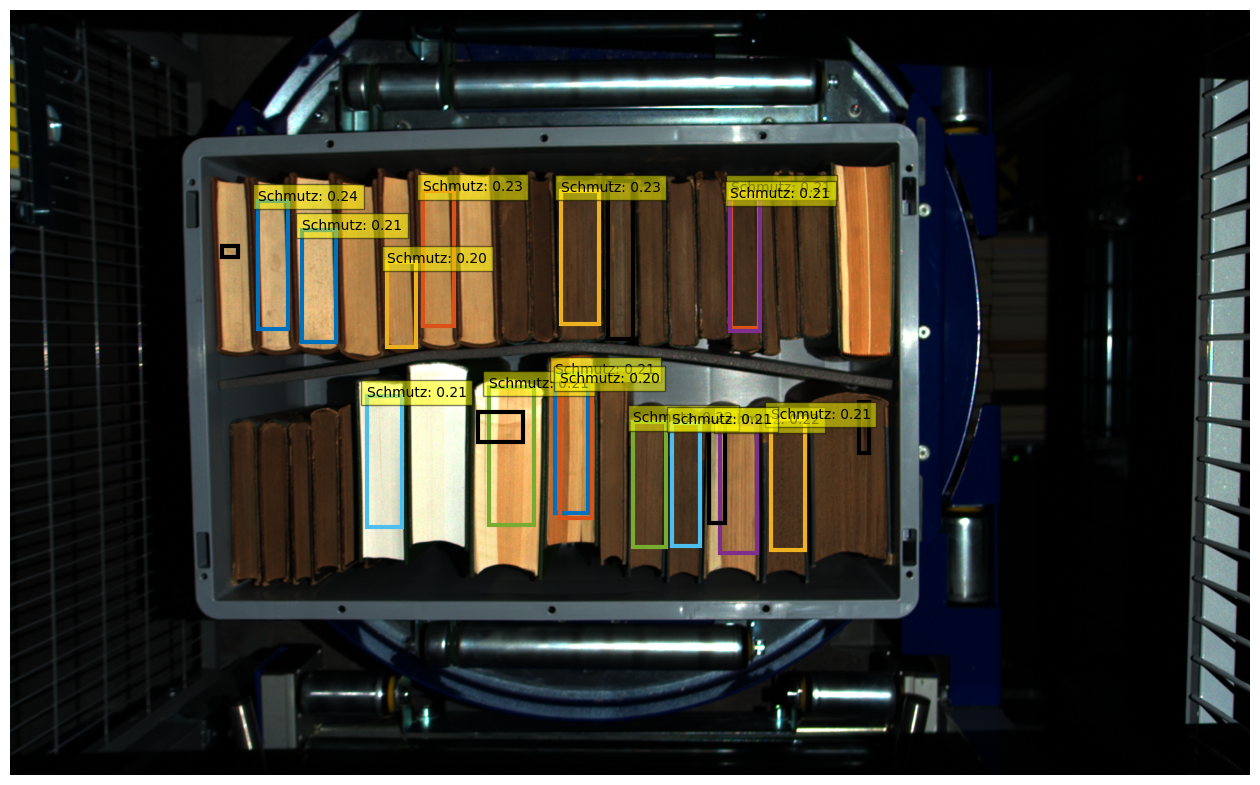

{'scores': tensor([0.2097, 0.2084], device='cuda:0'), 'labels': tensor([3, 3], device='cuda:0'), 'boxes': tensor([[1145.5861,  612.3091, 1188.6613,  847.8578],
        [ 850.9183,  288.4884,  910.7569,  517.1161]], device='cuda:0')}
{'Schmutz': 2}
{'Sonstiges': 2, 'Schmutz': 6}


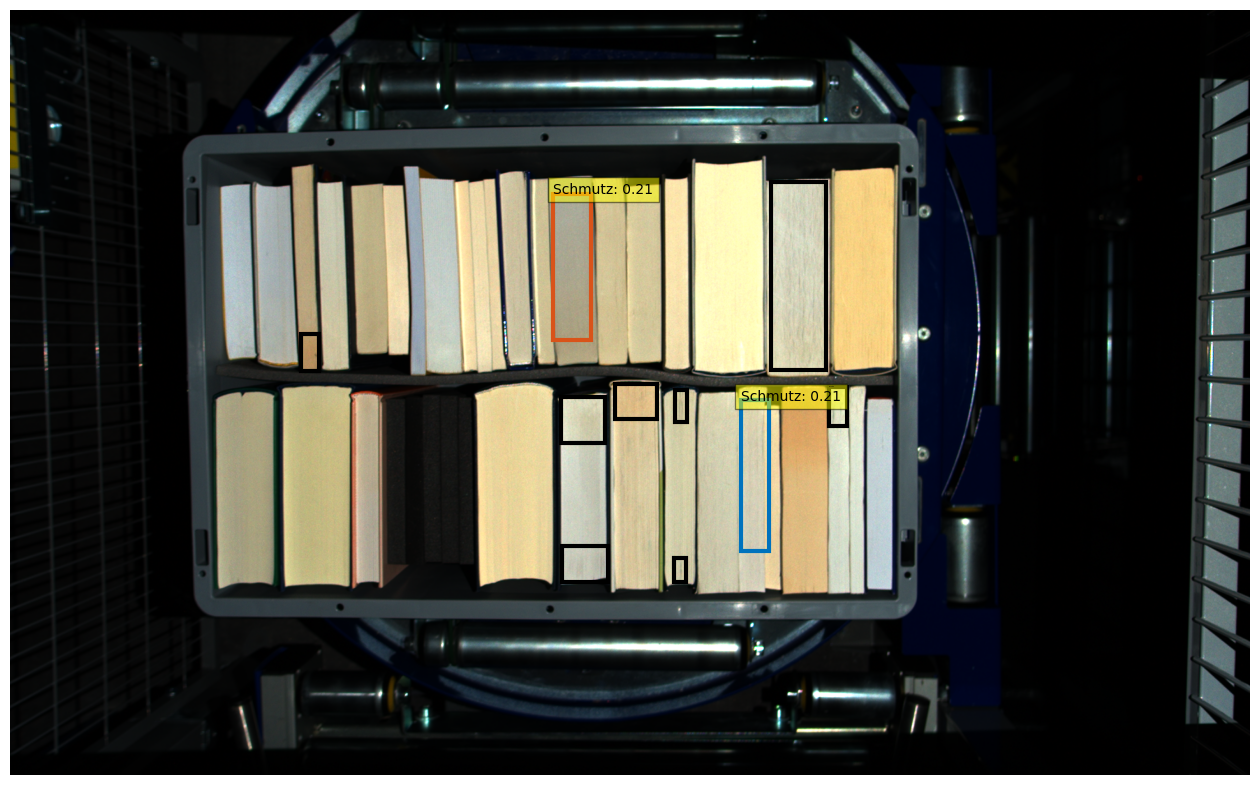

{'scores': tensor([0.2568, 0.2535, 0.2516, 0.2423, 0.2409, 0.2398, 0.2382, 0.2376, 0.2317,
        0.2281, 0.2274, 0.2249, 0.2230, 0.2220, 0.2211, 0.2209, 0.2209, 0.2209,
        0.2203, 0.2199, 0.2183, 0.2162, 0.2159, 0.2146, 0.2134, 0.2128, 0.2126,
        0.2124, 0.2123, 0.2119, 0.2111, 0.2107, 0.2104, 0.2075, 0.2072, 0.2066,
        0.2066, 0.2062, 0.2058, 0.2027, 0.2021, 0.2017, 0.2015, 0.2014, 0.2010,
        0.2000], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0'), 'boxes': tensor([[ 877.8300,  440.6862, 1045.8358,  538.8472],
        [ 631.9999,  337.1358,  720.3616,  437.1812],
        [ 651.0223,  508.2257,  823.0088,  612.4641],
        [1007.0160,  576.9790, 1102.8159,  672.2961],
        [ 896.9050,  548.2040, 1062.8695,  670.2870],
        [1025.6655,  686.1653, 1102.6964,  792.9828],
        [ 623.6593,  578.4800, 

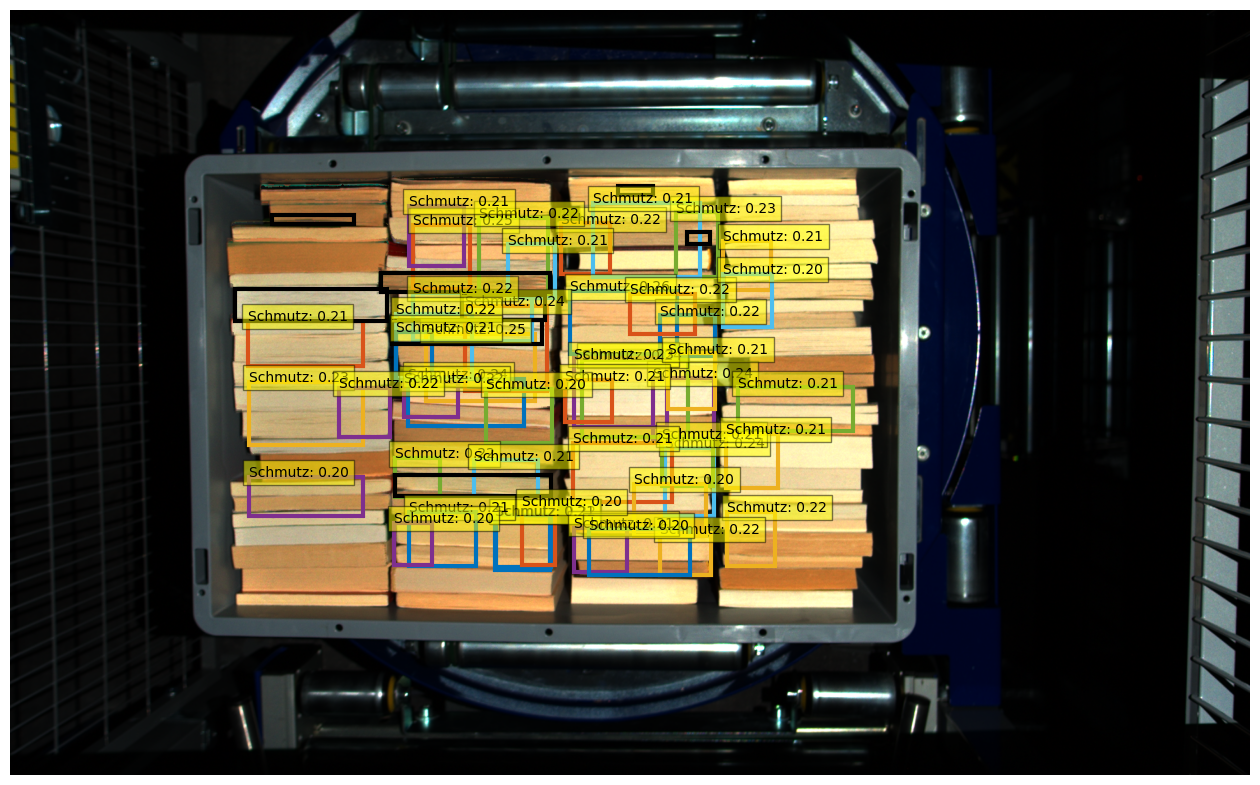

In [14]:
# Visualize
for z in range(6):
    pixel_values, target = val_dataset[z]
    pixel_values = pixel_values.unsqueeze(0).to(device)

    

    annotations = val_dataset.coco.imgToAnns["image_id"]

    with torch.no_grad():
        # forward pass to get class logits and bounding boxes
        outputs = model(pixel_values=pixel_values, pixel_mask=None)

    # colors for visualization
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
            [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

    def plot_results(pil_img, scores, labels, boxes, anno):
        plt.figure(figsize=(16,10))
        plt.imshow(pil_img)
        ax = plt.gca()
        colors = COLORS * 100
        types = {}
        for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=c, linewidth=3))
            text = f'{id2label[label]}: {score:0.2f}'
            textx = text.split(": ")
            if textx[0] in types:
                types.update({textx[0]: types[textx[0]] + 1})
            else: 
                types.update({textx[0]:1})
            ax.text(xmin, ymin, text, fontsize=10,
                    bbox=dict(facecolor='yellow', alpha=0.5))
        print(types)
        
        # draw annotatet boxes
        typesAnno = {}
        color = [0.000, 0.000, 0.000]
        # TODO Resize bbox
        for annot in anno:
            (x, y, w, h) = annot["bbox"]
            (xmin, ymin, xmax, ymax) = (x, y, x + w, y + h)
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=color, linewidth=3))
            text = f'{id2label[annot["category_id"]]}'
            if text in typesAnno:
                typesAnno.update({text: typesAnno[text] + 1})
            else: 
                typesAnno.update({text:1})
            ax.text(xmin, ymin, text, fontsize=0,
                    bbox=dict(facecolor='black', alpha=0.0))
        print(typesAnno)
        plt.axis('off')
        plt.show()

    # load image based on ID
    image_id = target['image_id'].item()
    image = val_dataset.coco.loadImgs(image_id)[0]
    anno = val_dataset.coco.imgToAnns[image_id]
    image = Image.open(os.path.join('../../../old/BAA/Data/val_max', image['file_name']))

    # postprocess model outputs
    width, height = image.size
    postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                    target_sizes=[(height, width)],
                                                                    threshold=0.2)
    results = postprocessed_outputs[0]
    print(results)
    plot_results(image, results['scores'], results['labels'], results['boxes'], anno)